In [560]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
!pip3 install seaborn

    100% |████████████████████████████████| 215kB 14.9MB/s ta 0:00:01
You are using pip version 19.0.3, however version 19.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [265]:
%load_ext autoreload
%autoreload 2
from utils import *

import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import os
import lightgbm as lgbm
import warnings
from utils import *
import seaborn as sns
from sklearn.metrics import accuracy_score
from parameters import top_tickers, ibkr_info

sns.set()

warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
np.array(list(ibkr_info.keys()))

array(['RNFT', 'PHOR', 'CBOM', 'POLY', 'TATNP', 'RTKM', 'PLZL', 'DSKY',
       'SFIN', 'IRAO', 'HYDR', 'RUAL', 'SNGSP', 'LKOH', 'MTLR', 'CHMF',
       'MVID', 'TATN', 'ALRS', 'MTSS', 'MGNT', 'NLMK', 'GAZP', 'GMKN',
       'YNDX', 'AFLT', 'AFKS', 'TRMK', 'MAGN', 'SNGS', 'FIVE', 'PIKK',
       'FEES', 'MOEX'], dtype='<U5')

In [3]:
load_tickers(data_prefix="data/train", tickers=np.array(list(ibkr_info.keys())), start_date=datetime.strptime("20170101", "%Y%m%d").date(), end_date=datetime.today().date() + timedelta(days=1), period=3)

 12%|█▏        | 5/41 [01:01<07:22, 12.29s/it]

DSKY


 17%|█▋        | 7/41 [01:15<06:01, 10.64s/it]

FIVE


 61%|██████    | 25/41 [04:44<02:58, 11.17s/it]

RNFT


 76%|███████▌  | 31/41 [05:50<02:04, 12.48s/it]

SFIN


100%|██████████| 41/41 [07:32<00:00, 11.35s/it]


In [9]:
ticker2df = load_dfs('data/train', np.array(list(ibkr_info.keys())))

RNFT
DSKY
SFIN
FIVE


In [561]:
test_start_day = datetime.today().date() - timedelta(days=30)

train_dates = [test_start_day - timedelta(days=x) for x in range(1, 800)]
val_dates = [test_start_day + timedelta(days=x) for x in range(0, 30)]

In [562]:
X_train, y_train_series = all_samples(ticker2df, train_dates)
X_val, y_val_series = all_samples(ticker2df, val_dates)

In [527]:
len(y_train_series)

30

In [482]:
len(y_train_series[0])

555

In [483]:
len(y_train_series[0][0])

211

In [451]:
X_train.shape

(8310, 76)

In [444]:
df

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,date
0,YNDX,5,20170103,100500,1254.0,1256.5,1248.0,1253.0,812,2017-01-03
1,YNDX,5,20170103,101000,1255.5,1255.5,1255.5,1255.5,32,2017-01-03
2,YNDX,5,20170103,101500,1255.0,1256.0,1255.0,1256.0,114,2017-01-03
3,YNDX,5,20170103,102000,1254.5,1254.5,1246.0,1246.0,279,2017-01-03
4,YNDX,5,20170103,102500,1247.5,1254.5,1246.5,1254.0,29,2017-01-03
5,YNDX,5,20170103,103000,1252.0,1256.0,1252.0,1255.5,143,2017-01-03
6,YNDX,5,20170103,103500,1255.5,1255.5,1255.0,1255.0,21,2017-01-03
7,YNDX,5,20170103,104000,1255.0,1255.5,1255.0,1255.5,2,2017-01-03
8,YNDX,5,20170103,104500,1255.5,1256.5,1255.5,1256.0,373,2017-01-03
9,YNDX,5,20170103,105000,1256.0,1257.5,1256.0,1256.5,94,2017-01-03


In [99]:
class Ansamble:
    def __init__(self):
        self.models = []
        

    def fit(self, X, y_series):
            
        for thr in [0.01, 0.015]:
            y_train = calc_target(y_series, single_target_3) > thr
            lgb = lgbm.sklearn.LGBMClassifier()
            self.models.append(lgb.fit(X.drop(['corn_date', 'ticker'], axis=1), y_train))    

        for thr in [0.0, 0.01, 0.015]:
            y_train = calc_target(y_series, single_target_2) > thr
            lgb = lgbm.sklearn.LGBMClassifier()
            self.models.append(lgb.fit(X.drop(['corn_date', 'ticker'], axis=1), y_train))    

        for thr in [0.0, 0.01, 0.015]:
            y_train = calc_target(y_series, single_target_4) > thr
            lgb = lgbm.sklearn.LGBMClassifier()
            self.models.append(lgb.fit(X.drop(['corn_date', 'ticker'], axis=1), y_train)) 

        for thr in [0.0, 0.01, 0.015]:
            y_train = calc_target(y_series, single_target_5) > thr
            lgb = lgbm.sklearn.LGBMClassifier()
            self.models.append(lgb.fit(X.drop(['corn_date', 'ticker'], axis=1), y_train)) 

        
    def predict_proba_matrix(self, X):
        all_probas = []
        for model in self.models:
            pred_proba = model.predict_proba(X.drop(['corn_date', 'ticker'], axis=1))[:, 1]
            all_probas.append(pred_proba)
            
        all_probas = np.array(all_probas)
        
        return all_probas
        
    def predict_proba(self, X):
        proba_matrix = self.predict_proba_matrix(X)
        proba = proba_matrix.sum()
        
        return proba
    
    

In [100]:
ansamble = Ansamble()

In [101]:
ansamble.fit(X_train, y_train_series)

In [102]:
proba_matrix = ansamble.predict_proba_matrix(X_val)

In [106]:
proba_matrix.shape

(11, 814)

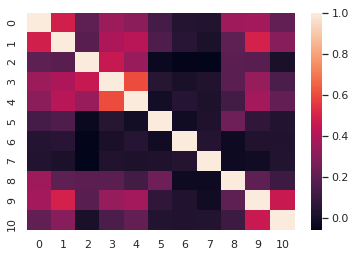

In [105]:
sns.heatmap(pd.DataFrame(proba_matrix.T).corr())

In [90]:
X_val

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,ticker,corn_date,profit,profit_abs
0,0.077103,0.904606,0.780060,0.949487,0.219940,0.180523,0.008859,0.982691,0.961667,0.981336,...,0.980005,0.791168,0.001204,0.014347,11.820,-0.005753,AFKS,2019-07-22,-0.007866,-1388.121856
1,0.074025,0.913466,0.782378,0.956443,0.217622,0.188970,0.006731,0.981667,0.962473,0.982158,...,0.978018,0.791171,0.006670,0.004321,11.730,-0.009548,AFKS,2019-07-23,0.010115,2167.445814
2,0.073529,0.916355,0.782378,0.959092,0.217622,0.187811,0.007015,0.985762,0.965465,0.986556,...,0.978018,0.791171,0.007829,0.040531,11.716,-0.000597,AFKS,2019-07-24,-0.005447,-1167.272595
3,0.072730,0.918671,0.782378,0.960583,0.217622,0.186403,0.005865,0.986781,0.973196,0.986808,...,0.973622,0.791171,0.004841,0.039123,11.699,-0.014959,AFKS,2019-07-25,-0.003157,-676.499269
4,0.068125,0.926342,0.785525,0.963564,0.214475,0.175141,0.004873,0.987572,0.979750,0.986808,...,0.969670,0.789858,0.001220,0.037775,11.695,-0.004446,AFKS,2019-07-26,0.000513,85.440875
5,0.047321,0.946922,0.805730,0.966628,0.194270,0.162968,0.006121,0.985108,0.961264,0.984035,...,0.968603,0.819467,NaN,0.001420,11.714,-0.002988,AFKS,2019-07-29,0.008344,1564.495530
6,0.037862,0.954530,0.819725,0.967787,0.180275,0.164624,0.006413,0.986657,0.962396,0.985194,...,0.969044,0.836114,NaN,0.015305,11.887,-0.000084,AFKS,2019-07-30,-0.003796,-569.380008
7,0.037436,0.955780,0.819725,0.968450,0.180275,0.163630,0.007425,0.984366,0.959168,0.981890,...,0.978148,0.836114,NaN,0.005207,11.875,-0.005137,AFKS,2019-07-31,0.018892,2982.898051
8,0.037403,0.936197,0.800955,0.946759,0.199045,0.177118,0.016462,0.957843,0.925641,0.955013,...,0.983916,0.815029,0.005843,0.020294,12.088,0.005212,AFKS,2019-08-01,0.015683,1960.418223
9,0.028419,0.943499,0.825148,0.948540,0.174852,0.156242,0.017889,0.965267,0.925641,0.960353,...,0.996468,0.826914,0.002714,0.009649,12.129,0.016407,AFKS,2019-08-02,-0.012971,-1768.733359


In [111]:
pred_proba = proba_matrix.sum(axis=0)

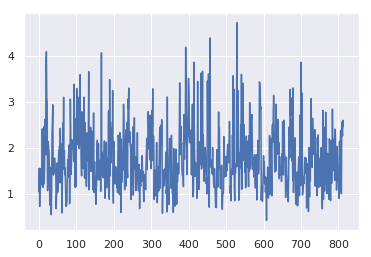

In [109]:
plt.plot(proba_matrix.sum(axis=0))


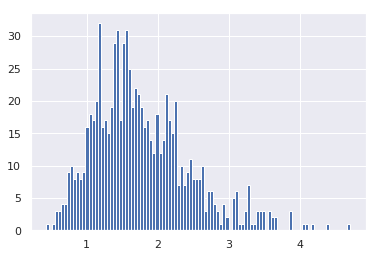

In [115]:
plt.hist(pred_proba, bins=100)
plt.show()

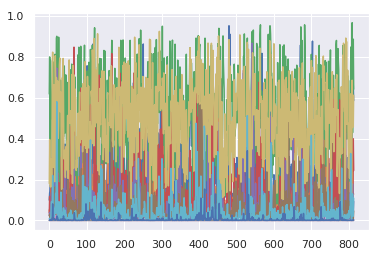

In [107]:
#plt.figure(figsize=(25,15))
for pred in proba_matrix:
    plt.plot(pred)

plt.show()

In [62]:
X_train.shape, X_val.shape

((2040, 76), (660, 78))

In [140]:
df_between(df, corn_date - timedelta(days=31), corn_date).groupby('date')['<OPEN>'].apply(lambda x: single_target_3(np.array([0]+x.tolist()))).values

array([ 0.00462907, -0.00096876,  0.00631068,  0.00810745,  0.01825168,
        0.014242  ,  0.01623832,  0.01103448, -0.0013782 ,  0.00842956,
       -0.00022949,  0.00482759,  0.00114943, -0.00022989, -0.00115929,
        0.01598282,  0.00304771,  0.00537313, -0.01507255,  0.00911854,
        0.00385871])

In [572]:
y_train_profit = calc_target(y_train_series, single_profit_2) 
y_val_profit = calc_target(y_val_series, single_profit_2)


y_train = calc_target(y_train_series, single_target_5) > 0.01
y_val = calc_target(y_val_series, single_target_5) > 0.01

lgb = lgbm.sklearn.LGBMClassifier()
lgb.fit(X_train.drop(['corn_date', 'ticker'], axis=1), y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [564]:
y_train

array([False, False, False, ...,  True,  True, False])

In [486]:
lgb.feature_importances_

array([ 47,  44,  29,  46,  11,  47,  26,  35,  43,  37,  32,  45,  42,
        38,  24,  48,  12,  47,  35,  27,  21,  36,  11,  55,  38,  24,
        23,  29,  10,  31,  43,  34,  33,  32,  19,  50,  14,  21,  49,
        52,  63,  38,  72,  59,  93, 100,  38,  59,  57,  62,   3,   0,
         4,  14,  37,  49,  75,  42,  36,  64,  41,  47,  50,  56,  52,
        71,  34,  58,  54,  32,  40,  53,  56,  51])

In [326]:
lgb.feature_importances_

array([35, 21, 20, 35, 21, 34, 52, 24, 26, 38, 20, 54, 45, 39, 17, 44, 19,
       59, 69, 27, 38, 41, 13, 62, 62, 49, 41, 44, 20, 58, 38, 27, 35, 42,
        8, 63,  3, 22, 56, 60, 65, 43, 81, 76, 49, 72, 59, 39, 33, 42, 12,
        0, 22,  9, 27, 38, 58, 41, 49, 39, 41, 39, 50, 28, 65, 43, 29, 49,
       69, 74, 37, 34, 71, 36])

In [31]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,66,67,68,69,70,71,72,73,ticker,corn_date
0,0.020548,0.959849,0.926772,0.962205,0.073228,-0.026772,0.005222,0.984692,0.976358,0.982580,...,-0.001298,0.013872,-0.021153,-0.001006,-0.001298,0.013872,-0.021153,-0.001006,PHOR,2019-07-24
1,0.020596,0.960750,0.926772,0.963386,0.073228,-0.031890,0.007173,0.981844,0.972325,0.978521,...,-0.001500,0.013872,-0.021153,-0.001207,-0.001500,0.013872,-0.021153,-0.001207,PHOR,2019-07-23
2,0.019604,0.962383,0.926772,0.964961,0.073228,-0.030709,0.007522,0.984391,0.972325,0.985750,...,-0.001069,0.013872,-0.021153,-0.000804,-0.001069,0.013872,-0.021153,-0.000804,PHOR,2019-07-22
3,0.017545,0.963554,0.926772,0.963780,0.073228,-0.027953,0.006685,0.986032,0.972325,0.987608,...,-0.000422,0.013872,-0.021153,-0.000804,-0.000422,0.013872,-0.021153,-0.000804,PHOR,2019-07-19
4,0.016308,0.964428,0.929134,0.963780,0.070866,-0.031102,0.005196,0.987654,0.974804,0.988021,...,-0.000452,0.013872,-0.021153,-0.000804,-0.000452,0.013872,-0.021153,-0.000804,PHOR,2019-07-18
5,0.015736,0.965553,0.929134,0.964567,0.070866,-0.016929,0.005808,0.984089,0.969199,0.984805,...,0.000322,0.013872,-0.021153,0.000005,0.000322,0.013872,-0.021153,0.000005,PHOR,2019-07-17
6,0.015545,0.966418,0.929134,0.966142,0.070866,-0.012598,0.009369,0.981421,0.963659,0.979584,...,0.000555,0.013872,-0.021153,0.000815,0.000555,0.013872,-0.021153,0.000815,PHOR,2019-07-16
7,0.014877,0.967101,0.929134,0.966142,0.070866,-0.022047,0.017085,0.965785,0.940614,0.960343,...,0.000279,0.013872,-0.021153,-0.000804,0.000279,0.013872,-0.021153,-0.000804,PHOR,2019-07-15
8,0.013582,0.967480,0.929134,0.964567,0.070866,-0.015748,0.018904,0.971673,0.937252,0.969817,...,0.000635,0.013872,-0.021153,0.000005,0.000635,0.013872,-0.021153,0.000005,PHOR,2019-07-12
9,0.012868,0.967855,0.940157,0.964567,0.059843,-0.002362,0.014518,0.980391,0.953535,0.988880,...,0.001407,0.013872,-0.018570,0.000005,0.001407,0.013872,-0.018570,0.000005,PHOR,2019-07-11


In [606]:
del X_val['profit']
del X_val['profit_abs']

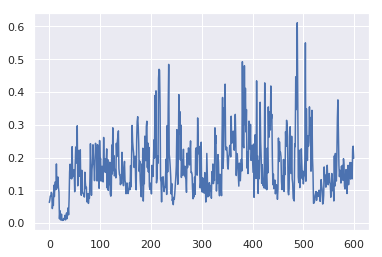

In [607]:
pred_proba = lgb.predict_proba(X_val.drop(['corn_date', 'ticker'], axis=1))[:, 1]
#pred_proba = lgb.predict(X_val.drop(['corn_date', 'ticker'], axis=1))

plt.plot(pred_proba)
plt.show()

# pred_proba_2 = lgb_2.predict_proba(X_val.drop(['corn_date', 'ticker'], axis=1))[:, 1]
# plt.plot(pred_proba_2)
# plt.show()

# pred_proba_3 = lgb_3.predict_proba(X_val.drop(['corn_date', 'ticker'], axis=1))[:, 1]
# plt.plot(pred_proba_3)

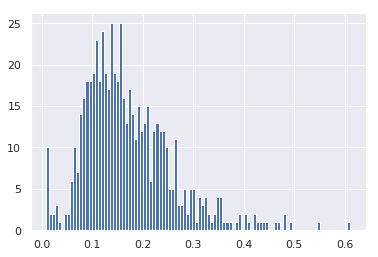

In [608]:
plt.hist(pred_proba, bins=100)
plt.show()

In [619]:
top_idxs = np.where(pred_proba > 0.4)[0]
#top_idxs = np.where(pred_proba > 0.4)[0]

#top_idxs = np.where(preds.sum(axis=0)/3 > 0.6)[0]


In [788]:
#top_idxs = np.argsort(pred_proba)[::-1][:30]

In [736]:
# X_val['pred'] = pred_proba
# day_thr_df = X_val.groupby('corn_date')['pred'].apply(lambda x: np.sort(x.tolist())[::-1][0]).reset_index().rename({'pred': 'day_thr_pred'}, axis=1)
# X_val = pd.merge(X_val, day_thr_df, on='corn_date', how='left')
# top_idxs = X_val[X_val['pred'] >= X_val['day_thr_pred']].index.values

# del X_val['day_thr_pred']
# del X_val['pred']

In [610]:
top_idxs

array([173, 174, 192, 208, 210, 215, 216, 217, 218, 234, 235, 255, 257,
       292, 341, 344, 345, 346, 358, 366, 380, 384, 385, 386, 388, 393,
       396, 408, 415, 424, 431, 433, 434, 436, 437, 438, 467, 485, 486,
       487, 488, 489, 504, 506, 512, 514, 517, 567, 568])

In [611]:
len(top_idxs)#, len(top_idxs_2), len(top_idxs_3)

49

In [620]:
y_val.mean(), y_val[top_idxs].mean()

(0.14666666666666667, 0.5625)

In [621]:
y_val.mean(), y_val[top_idxs].mean()

(0.14666666666666667, 0.5625)

In [585]:
y_train_profit = calc_target(y_train_series, single_profit_2) 
y_val_profit = calc_target(y_val_series, single_profit_2)


In [622]:
X_val['profit'] = y_val_profit
day_cnt_df = X_val.loc[top_idxs].groupby('corn_date').size().reset_index().rename({0:'cnt_per_day'}, axis=1)
X_val = pd.merge(X_val, day_cnt_df, on='corn_date', how='left')
X_val['volume'] = 2000000 / X_val['cnt_per_day']
X_val['profit_abs'] = X_val['volume'] * X_val['profit']
del X_val['cnt_per_day']
del X_val['volume']

In [602]:
X_val.loc[top_idxs]

,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,ticker,corn_date,profit,profit_abs
8,0.012158,0.953564,0.937027,0.951375,0.062973,-0.019928,0.007200,0.984444,0.972518,0.985234,...,0.001048,0.002346,1.011299,1.021610,1.004651,1.010208,PHOR,2019-08-08,0.012000,18000.0
21,0.002585,0.976350,0.969389,0.976101,0.030611,-0.005402,0.000990,0.994349,0.991832,0.994332,...,0.000210,0.000817,1.005765,1.023798,1.000840,1.004536,CBOM,2019-07-30,-0.000336,NaN
22,0.002532,0.976363,0.969389,0.976101,0.030611,-0.006384,0.000972,0.994469,0.991832,0.994499,...,0.000210,0.000820,1.005648,1.023798,1.000840,1.004456,CBOM,2019-07-31,-0.002183,NaN


In [623]:
X_val.loc[top_idxs].groupby('corn_date')['profit_abs'].sum()

corn_date
2019-07-29    24000.000000
2019-08-02     9743.984601
2019-08-05    24000.000000
2019-08-06    12000.000000
2019-08-07     2472.493510
2019-08-08    12000.000000
2019-08-12        0.000000
2019-08-19     6703.389831
2019-08-20    24000.000000
2019-08-21    24000.000000
Name: profit_abs, dtype: float64

In [624]:
X_val.loc[top_idxs]['profit_abs'].sum()

138919.8679407904

In [ ]:
251134.3917909803
149006.78436374138

In [212]:
78048 / 3000000

0.026016

In [22]:
X_val.loc[top_idxs]['profit_abs'].sum()

-205164.9234591169

In [ ]:
249540.7438308383
238265.8202385087
182758.77619388318
124229.31720323926
91517.8617101984
84287.5011097007

In [ ]:
274337.9430807853
175824.31807198492

In [423]:
X_day = X_val.loc[top_idxs]
X_day = X_day[X_day['corn_date'] == datetime.strptime("20190725", "%Y%m%d").date()]

In [424]:
X_day

,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,ticker,corn_date,profit,profit_abs
396,0.053447,0.930562,0.835445,0.962172,0.164555,-0.117961,0.004378,0.982793,0.970649,0.982651,...,0.001367,0.003435,1.021815,1.049158,1.007292,1.017586,FEES,2019-07-25,0.011724,17585.975882
418,0.016615,0.961091,0.918831,0.963281,0.081169,0.016079,0.004521,0.979043,0.968569,0.978367,...,0.001003,0.003278,1.016633,1.032018,1.005963,1.015443,YNDX,2019-07-25,0.036251,54377.077727


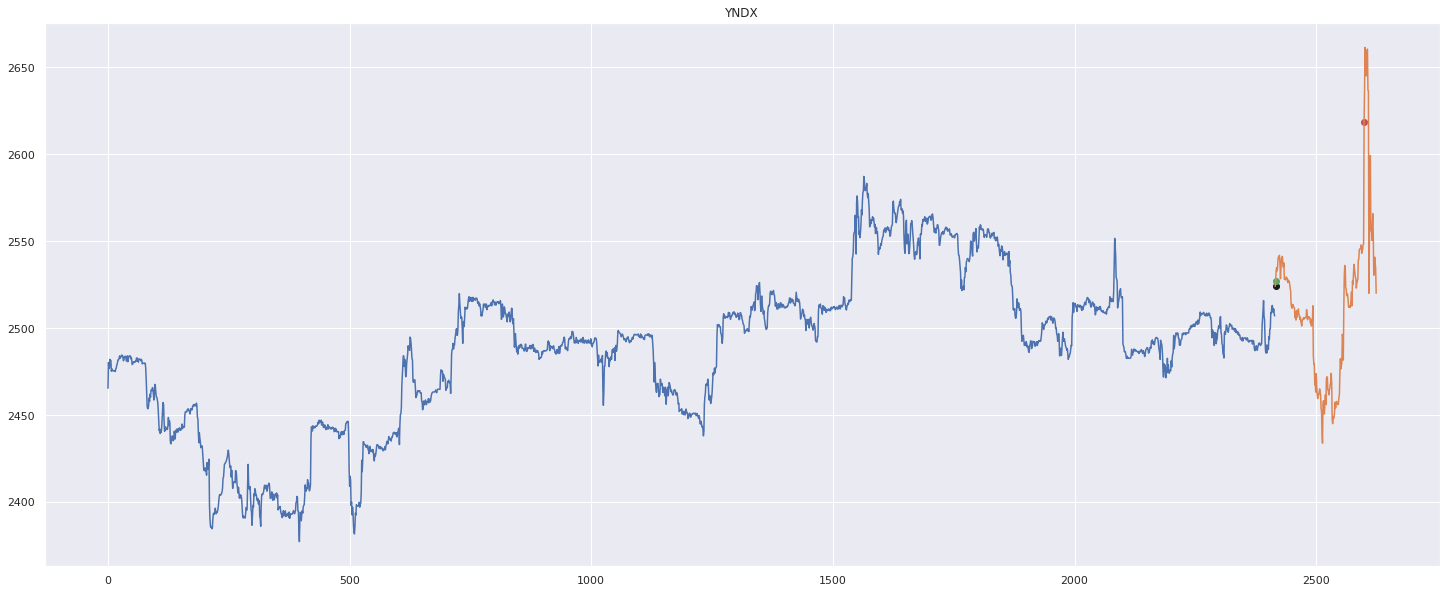

datetime.date(2019, 7, 25)

In [426]:
idx = 418
#for idx in top_idxs:
corn_date = X_val.loc[idx]['corn_date']
ticker = X_val.loc[idx]['ticker']

df = ticker2df[ticker]
month_series = df_between(df, corn_date - timedelta(days=31), corn_date)['<OPEN>'].values
target_series = df_between(df, corn_date, corn_date + timedelta(days=3))['<OPEN>'].values


plt.figure(figsize=(25,10))
plt.title(ticker)
plt.plot(range(len(month_series)), month_series)
plt.plot(range(len(month_series), len(month_series) + len(target_series)), target_series)

buy_idx, sell_idx = single_profit_2(np.array([0] + list(target_series)), return_idxs=True)
plt.scatter(len(month_series) + 1, target_series[0], color='k')
plt.scatter(len(month_series) + buy_idx - 1, target_series[buy_idx - 1], color='g')
plt.scatter(len(month_series) + sell_idx - 1, target_series[sell_idx - 1], color='r')

#plt.plot(range(len(month_series), len(month_series) + len(target_series)), y_val_series[84][-8], color='r')




plt.show()
corn_date

In [658]:
int(datetime.now().strftime('%H'))

20

In [659]:
lgb

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [661]:
import pickle
with open('models/lgb.pickle', 'wb') as f:
    pickle.dump(lgb, f)

# Inference

In [810]:

train_dates = [datetime.today().date() - timedelta(days=x) for x in range(1, 100)]


In [811]:
X_train, y_train_series = all_samples(ticker2df, train_dates)


In [812]:
y_train_profit = calc_target(y_train_series, single_profit_2) 

y_train = calc_target(y_train_series, single_target_3) > 0.01

lgb = lgbm.sklearn.LGBMClassifier()
lgb.fit(X_train.drop(['corn_date', 'ticker'], axis=1), y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [48]:
test_start_day

datetime.date(2019, 7, 4)

In [628]:
load_tickers(data_prefix="data/current", tickers=np.array(list(ibkr_info.keys())), start_date=datetime.today().date() - timedelta(days=40), end_date=datetime.today().date(), period=3)

  0%|          | 0/34 [00:00<?, ?it/s]

RNFT


 21%|██        | 7/34 [00:07<00:31,  1.16s/it]

DSKY
SFIN


 88%|████████▊ | 30/34 [00:33<00:05,  1.30s/it]

FIVE


100%|██████████| 34/34 [00:37<00:00,  1.24s/it]


In [635]:
ticker2df_test = load_dfs('data/current', np.array(list(ibkr_info.keys())))

RNFT
DSKY
SFIN
FIVE


In [636]:
X_test, y_test_series = all_samples(ticker2df_test, [datetime.today().date()], test_mode=True)

In [593]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,66,67,68,69,70,71,72,73,ticker,corn_date
0,0.021912,0.961773,0.926320,0.958432,0.073680,0.016154,0.015712,0.971969,0.949961,0.968085,...,0.002962,0.005075,0.001069,0.002631,1.012692,1.021382,1.004651,1.011240,PHOR,2019-08-26
1,0.005344,0.990636,0.975163,0.992665,0.024837,-0.016003,0.005170,0.989426,0.982368,0.987741,...,0.000870,0.002763,0.000299,0.000740,1.003794,1.014999,1.001347,1.002861,CBOM,2019-08-26
2,0.024822,0.945783,0.895979,0.952506,0.104021,-0.026224,0.004290,0.990284,0.976461,0.990363,...,0.004183,0.010455,0.001624,0.003069,1.018541,1.040062,1.007419,1.016541,TATNP,2019-08-26
3,0.007320,0.977200,0.962016,0.976350,0.037984,-0.027473,0.002954,0.990732,0.983537,0.990244,...,0.002643,0.006277,0.000899,0.002518,1.012019,1.020433,1.004574,1.011735,RTKM,2019-08-26
4,0.043475,0.941208,0.866068,0.951817,0.133932,0.108207,0.006055,0.986181,0.966585,0.985436,...,0.004520,0.013348,0.001063,0.003705,1.018291,1.045130,1.006192,1.016175,PLZL,2019-08-26
5,0.047560,0.922409,0.829764,0.930085,0.170236,0.100988,0.006268,0.980180,0.964710,0.980468,...,0.005376,0.013557,0.001388,0.004567,1.021719,1.043836,1.008658,1.020492,POLY,2019-08-26
6,0.016845,0.971317,0.933801,0.975281,0.066199,0.016760,0.017281,0.979397,0.938615,0.985921,...,0.004625,0.017513,0.001443,0.003438,1.018788,1.056400,1.007089,1.016185,LKOH,2019-08-26
7,0.019295,0.953514,0.927401,0.947405,0.072599,-0.070357,0.004449,0.989065,0.979243,0.989075,...,0.002871,0.005556,0.000863,0.002914,1.012536,1.018735,1.005510,1.012516,HYDR,2019-08-26
8,0.036919,0.935004,0.845376,0.951857,0.154624,-0.045392,0.023209,0.957845,0.915204,0.960152,...,0.005694,0.020482,0.001582,0.004768,1.024728,1.063531,1.007990,1.023045,AFKS,2019-08-26
9,0.010566,0.977043,0.946736,0.979064,0.053264,0.000154,0.009935,0.976814,0.960388,0.976726,...,0.003685,0.011759,0.000544,0.002576,1.015697,1.038844,1.002980,1.012572,SNGSP,2019-08-26


In [745]:
# del X_test['profit']
# del X_test['profit_abs']

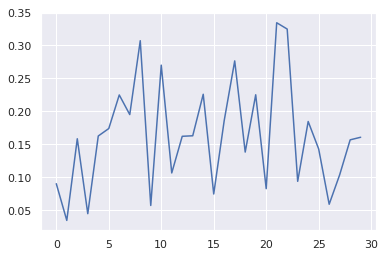

In [637]:
pred_proba = lgb.predict_proba(X_test.drop(['corn_date', 'ticker'], axis=1))[:, 1]
plt.plot(pred_proba)
plt.show()


In [821]:
16990000 * 0.039235

666602.65

In [638]:
top_idxs = np.where(pred_proba > 0.3)[0]
top_idxs

array([ 8, 21, 22])

In [632]:
ticker2price = {}

for ticker in list(X_test.loc[top_idxs, ['ticker', 'corn_date']]['ticker'].values):
    
    df = ticker2df_test[ticker]
    price = df[df['date']==datetime.today().date()]['<OPEN>'].values[0]
    
    ticker2price[ticker] = price


ticker2price

{'AFKS': 11.087, 'RUAL': 25.9, 'TRMK': 52.98}

In [639]:
y_test_series

[[array([2425., 2425., 2428., 2438., 2448., 2464., 2465., 2467., 2463.,
         2462., 2465., 2464., 2462., 2465., 2464., 2466., 2467., 2470.,
         2471., 2471., 2471., 2472., 2472., 2479., 2482., 2487., 2470.,
         2470., 2470., 2471., 2471., 2472., 2480., 2478., 2488., 2488.,
         2488., 2490., 2489., 2489., 2487., 2486., 2486., 2486., 2486.,
         2487., 2487., 2486., 2487., 2487., 2490., 2491., 2493., 2493.,
         2492., 2491., 2487., 2487., 2487., 2486., 2485., 2486., 2488.,
         2487., 2488., 2488., 2486., 2488., 2487., 2487., 2485., 2485.,
         2486., 2485., 2488., 2488., 2488., 2487., 2485., 2486., 2485.,
         2485., 2485., 2486., 2486., 2485., 2485., 2485., 2485., 2486.,
         2484., 2485., 2483., 2481., 2476., 2480., 2478., 2478., 2479.,
         2479., 2480., 2479., 2480.])],
 [array([5.855, 5.842, 5.849, 5.85 , 5.856, 5.859, 5.855, 5.854, 5.85 ,
         5.851, 5.853, 5.853, 5.857, 5.85 , 5.851, 5.853, 5.851, 5.851,
         5.852, 5.853, 5

In [640]:
y_test_profit = calc_target(y_test_series, single_profit_2)

In [647]:
X_test['profit'] = y_test_profit
day_cnt_df = X_test.loc[top_idxs].groupby('corn_date').size().reset_index().rename({0:'cnt_per_day'}, axis=1)
X_test = pd.merge(X_test, day_cnt_df, on='corn_date', how='left')
X_test['volume'] = 2000000 / X_test['cnt_per_day']
X_test['profit_abs'] = X_test['volume'] * X_test['profit']
del X_test['cnt_per_day']
del X_test['volume']

In [642]:
top_idxs

array([ 8, 21, 22])

In [643]:
X_test.loc[top_idxs, ['ticker', 'corn_date']]

,ticker,corn_date
8,AFKS,2019-08-26
21,RUAL,2019-08-26
22,TRMK,2019-08-26


In [648]:
X_test.loc[top_idxs, ['ticker', 'corn_date', 'profit', 'profit_abs']]

,ticker,corn_date,profit,profit_abs
8,AFKS,2019-08-26,0.012,8000.0
21,RUAL,2019-08-26,0.012,8000.0
22,TRMK,2019-08-26,0.012,8000.0


In [649]:
X_test.loc[top_idxs, ['profit']].sum()

profit    0.036
dtype: float64

In [650]:
X_test.loc[top_idxs, ['profit_abs']].sum()

profit_abs    24000.0
dtype: float64

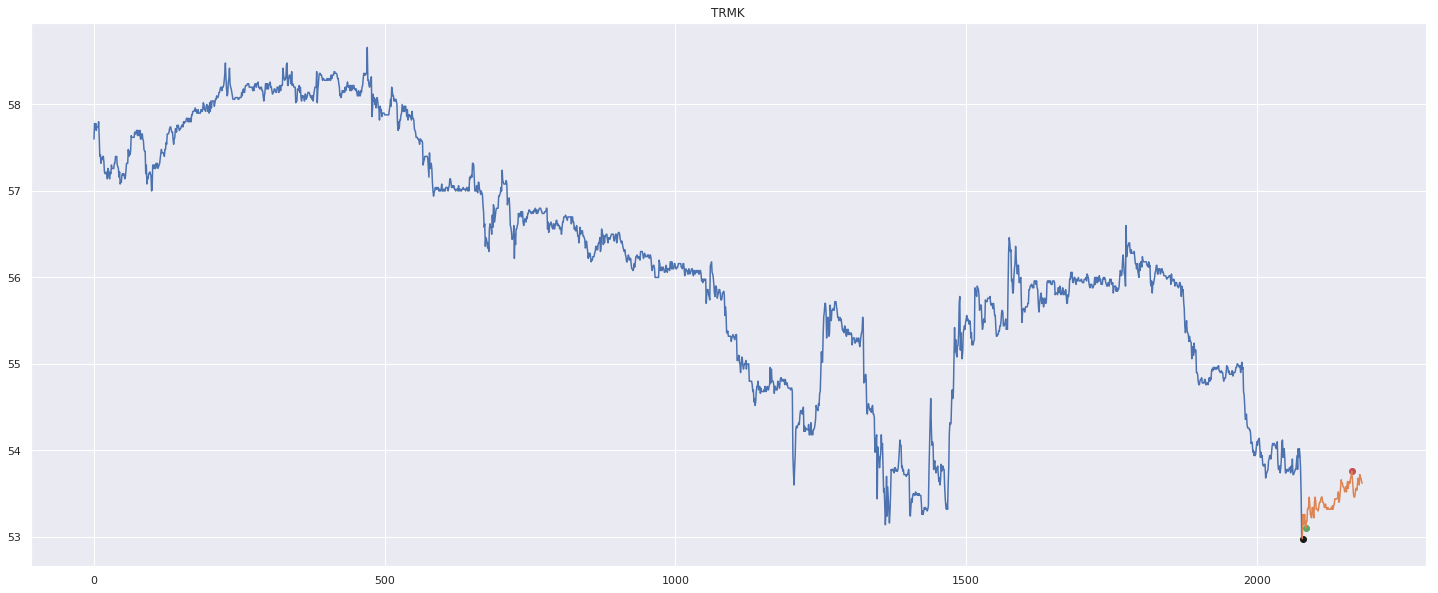

In [653]:
idx = 22
#for idx in top_idxs:
corn_date = X_test.loc[idx]['corn_date']
ticker = X_test.loc[idx]['ticker']

df = ticker2df_test[ticker]
month_series = df_between(df, corn_date - timedelta(days=31), corn_date)['<OPEN>'].values
target_series = df_between(df, corn_date, corn_date + timedelta(days=1))['<OPEN>'].values


plt.figure(figsize=(25,10))
plt.title(ticker)
plt.plot(range(len(month_series)), month_series)
plt.plot(range(len(month_series), len(month_series) + len(target_series)), target_series)

buy_idx, sell_idx = single_profit_2(np.array([0] + list(target_series)), return_idxs=True)
plt.scatter(len(month_series) + 1, target_series[0], color='k')
plt.scatter(len(month_series) + buy_idx - 1, target_series[buy_idx - 1], color='g')
plt.scatter(len(month_series) + sell_idx - 1, target_series[sell_idx - 1], color='r')

#plt.plot(range(len(month_series), len(month_series) + len(target_series)), y_val_series[84][-8], color='r')

# plt.axhline(y=11.573, linewidth=4, color='g')
# plt.axhline(y=11.675, linewidth=4, color='r')



plt.show()



In [353]:
    series = np.array([0] + list(target_series))
    UPPER_COEF = 1.003
    BUY_HORIZON = 118
    can_buy = (series[2:BUY_HORIZON] <= series[1]*UPPER_COEF).max()

In [354]:
can_buy

False

In [352]:
series[2:BUY_HORIZON] <= series[1]*UPPER_COEF

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [356]:
series

array([  0.  , 223.62, 225.25, 225.69, 225.52, 226.03, 225.69, 224.99,
       225.61, 225.81, 225.4 , 225.53, 225.33, 225.2 , 224.4 , 224.64,
       224.66, 225.03, 224.94, 225.13, 224.96, 225.48, 225.53, 225.64,
       225.49, 225.4 , 224.88, 225.23, 225.08, 225.3 , 225.35, 225.28,
       225.39, 225.35, 225.58, 225.59, 225.8 , 225.69, 225.45, 225.42,
       225.29, 225.27, 225.05, 225.26, 225.49, 225.4 , 225.33, 225.15,
       225.46, 225.44, 226.29, 226.2 , 225.98, 226.14, 226.12, 226.48,
       226.47, 227.21, 227.35, 226.8 , 226.63, 227.17, 227.06, 226.84,
       226.89, 226.69, 226.5 , 226.56, 226.31, 226.54, 226.55, 226.68,
       226.34, 226.4 , 226.55, 226.51, 226.4 , 226.53, 226.63, 226.28,
       226.7 , 226.12, 226.58, 226.69, 227.16, 227.23, 227.27, 227.17,
       226.93, 226.71, 226.93, 226.66, 226.99, 226.94, 226.95, 227.05,
       226.85, 226.95, 226.84, 226.61, 226.47, 226.54, 226.9 , 226.98,
       227.04, 226.76])

In [654]:
datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

AttributeError: type object 'datetime.datetime' has no attribute 'datetime'

In [ ]:
data_prefix='data/train'
start_date=datetime.today().date() - timedelta(days=1)
end_date = datetime.today().date() + timedelta(days=1)

ticker='LKOH'
load_single(ticker, 'data/temp', start_date, end_date, 3)


df = pd.read_csv('data/train/{}.csv'.format(ticker))
df['date'] = df['<DATE>'].apply(lambda x: datetime.strptime(str(x), "%Y%m%d").date())

upd_df = pd.read_csv('data/temp/{}.csv'.format(ticker))
upd_df['date'] = upd_df['<DATE>'].apply(lambda x: datetime.strptime(str(x), "%Y%m%d").date())